\title{Prototype and Trial programming of a LXI scope with Python Socket library without VISA}
\author{Steven K Armour}
\maketitle

# References
+ Python for LXI Instrument Control by Eric Jacobson http://gpete.blogs.keysight.com/2015/07/python-for-lxi-instrument-control.html

+ Rigol MSO1000Z/DS1000Z Series Digital Oscilloscope Programming Guide http://int.rigol.com/File/TechDoc/20151218/MSO1000Z&DS1000Z_ProgrammingGuide_EN.pdf


In [1]:
#Libraries that are needed
import socket #library that will do the connection between computer and LXI inst
import time #used to pause program to handle non asynchronous actions
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

In [2]:
class ScopeSocket():
    """
    Prototype class for establishing computer to scope connection via socket 
    (IP4) programming via the SCPI LXI protocol
    
    """
    def __init__(self, ScopeIP, ScopePort):
        """
        initlizes the class instincince
        
        Args:
            ScopeIP (str): the IP address of the target scope
            ScopePort (str): the socket port on the scope 
            ex Rigol DS scopes use 5555
        
        """
        #bind the IP and Port to the object
        self.ScopeIP=ScopeIP; self.ScopePort=ScopePort
    
    def SocketInit(self, TimeOutSec=3.0):
        """
        Method to startup the socket interconnect
        
        Args:
            None
            
        Note:
            good intro to sockets: 
            http://www.pythonforbeginners.com/code-snippets-source-code/port-scanner-in-python
        """
        # create socket instance in the class that is a streaming IP4
        self.s=socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        # set socket options
        self.s.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, 0)
        
        self.s.settimeout(TimeOutSec)
        
        #make the connection to the scope
        self.s.connect((self.ScopeIP, self.ScopePort))
    
    def SocketClose(self):
        """
        Method for closeing the socket (IP4) connection
        Args:
            None
        """
        self.s.close()
        print('Scope Socket Closed')
    
    def Command(self, cmd):
        """
        Convince  Method to pass SCPI commands over the socket such that for
        Rigol scopes the command is auto ended with a '\n' and is encoded to 
        Ascii bit and send on the socket connection. Most useful is sending
        commands and not quarries 
        
        Args:
            cmd (str): SCPI command to be sent needs to be in all caps
            example '*RST' will reset the scope; see the programing guide
        """
        cmd=f'{cmd}\n'
        self.s.sendall(cmd.encode())
    
    def Responce(self, resBitLen=12):
        """
        Convince Method for reciving the response of a quarry from the scope.
        This methods return returns the raw retrived bit 
        
        Args:
            resBitLen (int): the N in 2^N to specify the returned informtion 
            package
        
        Returns:
            returns the response information from the scope as is
        """
        return self.s.recv(2**resBitLen)
    
    def Quarry(self, cmd, resBitLen=12, Ascii=True):
        """
        Convince Method for sending qurry (ask for -> receive) commands that
        will send the SCPI commands and automatically get the responce from
        the scope and will return the result 
        
        Args:
            cmd (str): SCPI command to be sent needs to be in all caps
            example '*IDN?' will ask the scope for its IDN number; 
            see the programing guide
            
            resBitLen (int): the N in 2^N to specify the returned informtion 
            package
            
            Ascii (bool:Default True): if True will try to return the response
            from the Quarry as a string assuming "utf-8" ascii decoding
        
        Returns:
            str from decoded response if Arg Ascii is True 
            
            raw response of Arg Ascii is False
        
        """
        #prep and send command
        cmd=f'{cmd}\n'
        self.s.sendall(cmd.encode())
        
        # get the response
        res=self.s.recv(2**resBitLen)
        
        if Ascii:
            # attempt at byte to 'utf-8' decoding
            try:
                if res.decode('utf-8')=='command error':
                    print(f'Command: "{cmd}" is invalaid')
                else:
                    return res
            except:
                pass
        else:
            return res
            

    

# Begin Testing

## Test setup:
The testing for a analog signal  input to the scope was done via a sine wave from a generic benchtop signal generator connected to the scopes Channel 1 with all other channels left open

## Connection

In [3]:
ScopeIP="192.168.2.5"
#Supnet:255, 255 0
ScopePort = 5555

In [4]:
Rigol=ScopeSocket(ScopeIP, ScopePort)
Rigol.SocketInit()

### Confirm with IDN grap

In [5]:
Rigol.Quarry('*IDN?')

b'RIGOL TECHNOLOGIES,DS1104Z,DS1ZA173719352,00.04.03.SP1\n'

In [6]:
#test bad quarry
Rigol.Quarry('IDN?')

Command: "IDN?
" is invalaid


## Running Commands
pg 17

In [7]:
#auto scetup command
Rigol.Command('AUT')

In [8]:
Rigol.Command('STOP')

In [9]:
Rigol.Command('RUN')

In [10]:
Rigol.Command('STOP')

In [11]:
#clear the reading from the screen
Rigol.Command('CLE')

In [12]:
#do a signle measurment
Rigol.Command('SING')

## Measurment Commands

In [13]:
# Meausre qurry command,  what is being measured, where is the measuement from
#page 141

#Ch2 was not connected
Rigol.Quarry('MEAS:ITEM? VMAX, CHAN2') 

b'9.9E37\n'

In [14]:
# Meausre qurry command,  what is being measured, where is the measuement from

#Ch1 connected to sine genrator
Rigol.Quarry('MEAS:ITEM? VMAX, CHAN1') 

b'2.360000e+01\n'

## Math Commands

In [15]:
#Set up the scopes FFT
Rigol.Command('MATH:FFT:SOUR:CHAN1')

In [16]:
#Disapley the FFT on the scope display
Rigol.Command('MATH:DISP ON')

In [17]:
#Turn off disapley the FFT on the scope display
Rigol.Command('MATH:DISP OFF')

## Wavefrom acustion

### ASCII acqusisiton

In [18]:
# set output to be ascii bit encodeing; pg 234
Rigol.Command('WAV:FORM ASC')

In [19]:
# tell it the source of the waveform; pg 233
Rigol.Command('WAV:SOUR CHAN1')

In [20]:
# tell it how to get the wave form; pg 234
Rigol.Command('WAV:MODE NORM')

In [21]:
#grap the preamble ; pg 242
Preamble=Rigol.Quarry('WAV:PRE?', 16); Preamble

b'2,0,1200,1,5.000000e-06,-3.000000e-03,0,2.000000e-01,-44,127\n'

In [22]:
Preamble=Preamble.decode('utf-8'); Preamble

'2,0,1200,1,5.000000e-06,-3.000000e-03,0,2.000000e-01,-44,127\n'

In [23]:
PreambleDF=pd.DataFrame(columns=['Parm', 'Value'])
PreambleDF['Parm']=['format', 'type', 'points', 'count', 
                    'xincrement', 'xorigin', 'xreference', 
                    'yincrement', 'yorigin', 'yreference']
PreambleDF['Value']=[float(i) for i  in Preamble.split(',')]
PreambleDF

,Parm,Value
0,format,2.000000
1,type,0.000000
2,points,1200.000000
3,count,1.000000
4,xincrement,0.000005
5,xorigin,-0.003000
6,xreference,0.000000
7,yincrement,0.200000
8,yorigin,-44.000000
9,yreference,127.000000


In [24]:
#grap the wavefrom from the screen; pg 235
Data1=Rigol.Quarry('WAV:DATA?', 32)
Data1

b'#90000159286.799988e+00,8.599987e+00,7.599988e+00,8.999987e+00,8.199987e+00,9.599986e+00,8.599987e+00,1.019999e+01,9.199986e+00,1.099998e+01,9.799986e+00,1.159998e+01,1.059999e+01,1.219998e+01,1.119998e+01,1.279998e+01,1.159998e+01,1.319998e+01,1.219998e+01,1.379998e+01,1.279998e+01,1.439998e+01,1.339998e+01,1.479998e+01,1.399998e+01,1.519998e+01,1.439998e+01,1.579998e+01,1.479998e+01,1.659998e+01,1.539998e+01,1.679998e+01,1.579998e+01,1.719998e+01,1.619998e+01,1.779999e+01,1.659998e+01,1.839999e+01,1.739998e+01,1.859999e+01,1.779999e+01,1.939999e+01,1.799999e+01,1.959999e+01,1.859999e+01,1.999999e+01,1.899999e+01,2.020000e+01,1.939999e+01,2.080000e+01,1.979999e+01,2.120000e+01,2.120000e+01,1.999999e+01,2.020000e+01,2.160000e+01,2.060000e+01,2.200000e+01,2.080000e+01,2.220000e+01,2.120000e+01,2.240000e+01,2.120000e+01,2.260000e+01,2.140000e+01,2.280000e+01,2.160000e+01,2.300001e+01,2.180000e+01,2.300001e+01,2.200000e+01,2.320001e+01,2.320001e+01,2.200000e+01,2.220000e+01,2.340001e+01

In [25]:
Data2=Rigol.Responce(32); Data2

b'99e+01,2.040000e+01,1.899999e+01,2.020000e+01,1.859999e+01,1.959999e+01,1.819999e+01,1.799999e+01,1.939999e+01,1.879999e+01,1.739998e+01,1.839999e+01,1.679998e+01,1.779999e+01,1.619998e+01,1.719998e+01,1.579998e+01,1.699998e+01,1.539998e+01,1.639998e+01,1.479998e+01,1.579998e+01,1.459998e+01,1.539998e+01,1.379998e+01,1.479998e+01,1.339998e+01,1.419998e+01,1.279998e+01,1.379998e+01,1.219998e+01,1.319998e+01,1.179998e+01,1.259998e+01,1.119998e+01,1.199998e+01,1.079998e+01,1.159998e+01,9.999986e+00,1.099998e+01,9.399986e+00,1.019999e+01,8.799987e+00,9.799986e+00,7.999987e+00,9.199986e+00,7.599988e+00,8.599987e+00,6.999988e+00,7.799987e+00,6.399989e+00,7.399988e+00,5.799989e+00,6.799988e+00,5.199990e+00,6.199989e+00,4.799990e+00,5.799989e+00,4.199991e+00,4.999990e+00,3.599991e+00,4.599990e+00,2.999990e+00,3.999991e+00,2.599990e+00,3.599991e+00,1.999990e+00,2.799990e+00,1.399990e+00,2.399990e+00,1.199990e+00,2.199990e+00,5.999902e-01,1.599990e+00,1.999902e-01,9.999902e-01,-6.000098e-01,7.

In [26]:
#Need to get time out working
#Data3=Rigol.Responce(32); Data3

In [27]:
Data1==Data2

False

Need to figure out the call sizes and how to clear the output buffer

In [28]:
Data=Data1.decode('utf-8')+Data2.decode('utf-8'); Data

'#90000159286.799988e+00,8.599987e+00,7.599988e+00,8.999987e+00,8.199987e+00,9.599986e+00,8.599987e+00,1.019999e+01,9.199986e+00,1.099998e+01,9.799986e+00,1.159998e+01,1.059999e+01,1.219998e+01,1.119998e+01,1.279998e+01,1.159998e+01,1.319998e+01,1.219998e+01,1.379998e+01,1.279998e+01,1.439998e+01,1.339998e+01,1.479998e+01,1.399998e+01,1.519998e+01,1.439998e+01,1.579998e+01,1.479998e+01,1.659998e+01,1.539998e+01,1.679998e+01,1.579998e+01,1.719998e+01,1.619998e+01,1.779999e+01,1.659998e+01,1.839999e+01,1.739998e+01,1.859999e+01,1.779999e+01,1.939999e+01,1.799999e+01,1.959999e+01,1.859999e+01,1.999999e+01,1.899999e+01,2.020000e+01,1.939999e+01,2.080000e+01,1.979999e+01,2.120000e+01,2.120000e+01,1.999999e+01,2.020000e+01,2.160000e+01,2.060000e+01,2.200000e+01,2.080000e+01,2.220000e+01,2.120000e+01,2.240000e+01,2.120000e+01,2.260000e+01,2.140000e+01,2.280000e+01,2.160000e+01,2.300001e+01,2.180000e+01,2.300001e+01,2.200000e+01,2.320001e+01,2.320001e+01,2.200000e+01,2.220000e+01,2.340001e+01,

In [29]:
#strip of leading 11 junk and traling new line
Data=Data[11:-1]; Data

'6.799988e+00,8.599987e+00,7.599988e+00,8.999987e+00,8.199987e+00,9.599986e+00,8.599987e+00,1.019999e+01,9.199986e+00,1.099998e+01,9.799986e+00,1.159998e+01,1.059999e+01,1.219998e+01,1.119998e+01,1.279998e+01,1.159998e+01,1.319998e+01,1.219998e+01,1.379998e+01,1.279998e+01,1.439998e+01,1.339998e+01,1.479998e+01,1.399998e+01,1.519998e+01,1.439998e+01,1.579998e+01,1.479998e+01,1.659998e+01,1.539998e+01,1.679998e+01,1.579998e+01,1.719998e+01,1.619998e+01,1.779999e+01,1.659998e+01,1.839999e+01,1.739998e+01,1.859999e+01,1.779999e+01,1.939999e+01,1.799999e+01,1.959999e+01,1.859999e+01,1.999999e+01,1.899999e+01,2.020000e+01,1.939999e+01,2.080000e+01,1.979999e+01,2.120000e+01,2.120000e+01,1.999999e+01,2.020000e+01,2.160000e+01,2.060000e+01,2.200000e+01,2.080000e+01,2.220000e+01,2.120000e+01,2.240000e+01,2.120000e+01,2.260000e+01,2.140000e+01,2.280000e+01,2.160000e+01,2.300001e+01,2.180000e+01,2.300001e+01,2.200000e+01,2.320001e+01,2.320001e+01,2.200000e+01,2.220000e+01,2.340001e+01,2.220000e+0

In [30]:
Data=np.array([float(i) for i in Data.split(',')])
Data

array([ 6.799988,  8.599987,  7.599988, ...,  8.999987,  7.799987,
        9.599986])

In [31]:
PreambleDF, len(Data)

(         Parm        Value
 0      format     2.000000
 1        type     0.000000
 2      points  1200.000000
 3       count     1.000000
 4  xincrement     0.000005
 5     xorigin    -0.003000
 6  xreference     0.000000
 7  yincrement     0.200000
 8     yorigin   -44.000000
 9  yreference   127.000000, 1200)

In [32]:
x=np.arange(0, (1200)*0.000005, 0.000005)
x[0], x[-1]

(0.0, 0.0059950000000000003)

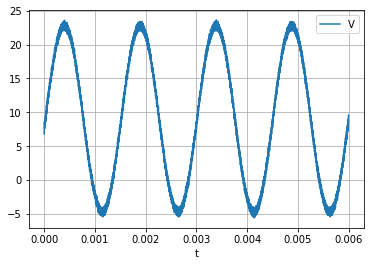

In [33]:
DataAscii=pd.DataFrame(columns=['t', 'V'])
DataAscii['t']=x; DataAscii['V']=Data
DataAscii.plot(x='t', y='V')
plt.grid()

In [34]:
PreambleDF.to_pickle('asciiPreamble.p')
DataAscii.to_pickle('asciiData.p')

### byte

### WORD

# Decode rs-232 command *IDN?